In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj
from matplotlib.collections import PatchCollection
from descartes.patch import PolygonPatch
from pyproj import Proj, transform

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
import fiona
from fiona.crs import to_string

from itertools import chain

import urllib

import geopandas as gpd

Import habitat model coverage

In [2]:
with fiona.open('data/HabModelEnviro.shp') as shp:
    
    records = list(shp)
    hab_model_bounds = shp.bounds
    hab_model_json = {"type": "FeatureCollection", "features": records}
    hab_model_crs = shp.crs

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: Read cursor may be altered. This can lead to side effects
  app.launch_new_instance()


In [3]:
epsg26717_str = urllib.request.urlopen('http://spatialreference.org/ref/epsg/26717/proj4/').read().decode("utf-8")
epsg26717_str

'+proj=utm +zone=17 +ellps=clrk66 +datum=NAD27 +units=m +no_defs '

In [4]:
hab_model_crs

{'init': 'epsg:26717'}

In [5]:
wgs84 = Proj(init='EPSG:4326')

In [6]:
hab_model_proj = Proj(hab_model_crs)

In [7]:
ll = hab_model_bounds[0], hab_model_bounds[1]
ur = hab_model_bounds[2], hab_model_bounds[3]
coords = list(chain(ll, ur))

# Convert to WGS84
coords_wgs = hab_model_proj(*coords[:2], inverse=True) + hab_model_proj(*coords[2:], inverse=True)
w, h = coords_wgs[2] - coords_wgs[0], coords_wgs[3] - coords_wgs[1]

In [8]:
extra = 0.01

southeast = Basemap(ax=None,
    llcrnrlon=coords_wgs[0] - extra * w,
    llcrnrlat=coords_wgs[1] - extra + 0.01 * h,
    urcrnrlon=coords_wgs[2] + extra * w,
    urcrnrlat=coords_wgs[3] + extra + 0.01 * h,
    resolution='i',
    epsg='4326')

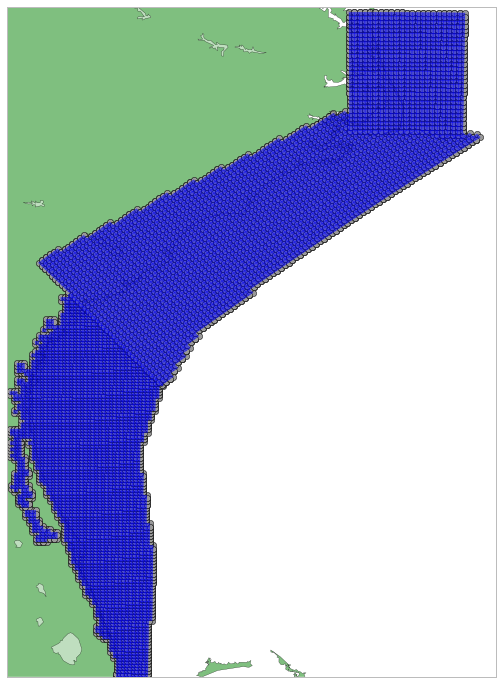

In [9]:
from matplotlib.pyplot import cm, colorbar
#from mpl_toolkits.basemap import Polygon, PolyCollection

fig = plt.figure(figsize=(16,12))
ax = plt.gca()
southeast.drawcoastlines(linewidth=0.25)
southeast.fillcontinents(zorder=-1, color='green', alpha=0.5)

mp = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open('data/HabModelEnviro_WGS84.shp')])

# patches = []
# for poly in mp:
#     #colour = cm(1. * len(filter(poly.contains, points)) / num_colours)
#     patches.append(PolygonPatch(poly, fc=colour, ec='#555555', lw=0.2, alpha=1., zorder=1))
# pc = PatchCollection(patches, match_original=True)
# ax.add_collection(pc)

def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#999999', zorder=1)
    
for polygon in mp:
    plot_coords(ax, polygon.exterior)
    patch = PolygonPatch(polygon, facecolor='blue', edgecolor='blue', alpha=0.5, zorder=2)
    ax.add_patch(patch)

# z = [state_cases[i]*(i!='SAO PAULO') for i in municipio]
# coll = PolyCollection(SP_region.region, array=np.array(z), cmap=cm.Blues, edgecolors='none')
# ax.add_patch(mp)
# colorbar(coll, ax=ax, shrink=0.7)

# sp_poly = Polygon(SP_region.region[municipio.index('SAO PAULO')], facecolor='black')
# ax.add_patch(sp_poly)


plt.show()

Import data to GeoPandas

In [10]:
HabModelEnviro = gpd.GeoDataFrame.from_file('data/HabModelEnviro.shp').replace({-999: None})

In [11]:
WGS84_crs = urllib.request.urlopen('http://spatialreference.org/ref/epsg/4326/proj4/').read().decode("utf-8")

In [12]:
HabModelEnviroWGS84 = HabModelEnviro.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Truncate to area of interest (31o41' to 33o)

In [13]:
upper_limit = 33
lower_limit = 31.683

In [14]:
HabModelEnviroSC = HabModelEnviroWGS84[(lower_limit < HabModelEnviroWGS84.Lat) & 
                                       (HabModelEnviroWGS84.Lat < upper_limit)]

In [15]:
coords_wgs[2] + extra * w

-73.98715980985588

In [16]:
coords_wgs[0] - extra * w

-81.80591199654882

Import nav channel layer

In [17]:
navchannel = gpd.GeoDataFrame.from_file('data/SHEP_navchannel.shp')

In [18]:
navchannelWGS84 = navchannel.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

In [19]:
basemap_sc = Basemap(ax=None,
    llcrnrlon=-81.5,
    llcrnrlat=lower_limit - extra*w,
    urcrnrlon=-77.5,
    urcrnrlat=upper_limit + extra*w,
    resolution='i',
    epsg='4326')

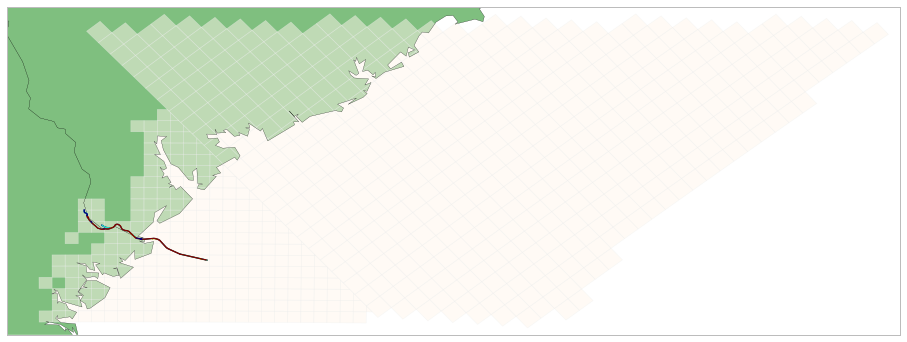

In [20]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelEnviroSC.plot(column='sstmar13b', k=5, colormap='OrRd', linewidth=0, axes=ax)
navchannelWGS84.plot(column='Color', axes=ax)

Import survey data

In [21]:
HabModelSurvey = gpd.GeoDataFrame.from_file('data/HabModelSurvey.shp')

Reproject to GGS84

In [22]:
HabModelSurveyWGS84 = HabModelSurvey.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Clip to area of interest

In [23]:
HabModelSurveySC = HabModelSurveyWGS84[(lower_limit < HabModelSurveyWGS84.Lat) 
                                       & (HabModelSurveyWGS84.Lat < upper_limit)]

In [24]:
HabModelSurveySC.GrpsJan10B.value_counts()

0    802
1      3
dtype: int64

Colormap for binary features

In [25]:
import matplotlib
binary_cm = matplotlib.colors.ListedColormap(np.array([[255,255,255], [0,0,0]])/255)

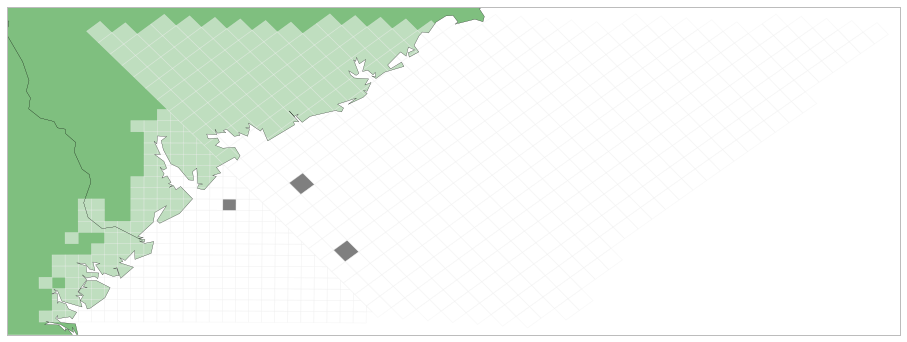

In [26]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelSurveySC.plot(column='GrpsJan10B', k=2, colormap=binary_cm, linewidth=0, axes=ax)

Perform a merge of survey and habitat data

In [27]:
# Use lower case for trailing A and B times
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelEnviroSC.columns if c.endswith('A') or c.endswith('B')}
HabModelEnviro_points = HabModelEnviroSC.copy().rename(columns=replace_dict)
HabModelEnviro_points.geometry = HabModelEnviro_points.geometry.centroid

In [28]:
from geopandas.tools import sjoin

replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelSurveySC.columns if c.endswith('A') or c.endswith('B')}
HabModel_merged = sjoin(HabModelSurveySC.rename(columns=replace_dict), HabModelEnviro_points, how="left")

In [29]:
# Drop cells with null DistToShor values (land)
HabModel_merged = HabModel_merged.dropna(subset=['DistToShor'])

SST and whales for an arbitrary month

In [30]:
HabModel_merged = HabModel_merged[HabModel_merged.DistToShor>10000]

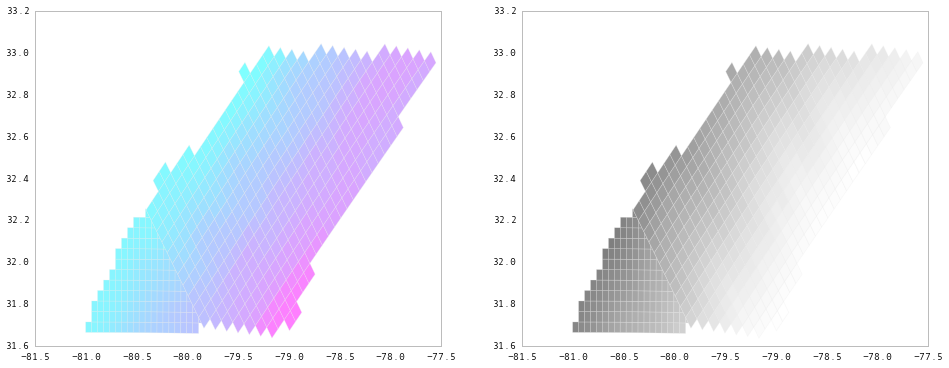

In [31]:
f, axes = plt.subplots(1, 2, figsize=(16, 6))

HabModel_merged.plot(column='sstjan12b', k=8, colormap='cool', linewidth=0, axes=axes[0])

HabModel_merged.plot(column='isomar04b', k=10, colormap='Greys', linewidth=0, axes=axes[1])


Convert data into long format and remove time information from column names. We are breaking the data into one table for each 2-week period.

In [32]:
time_intervals = ['Dec03a','Dec03b','Dec04a','Dec04b','Dec05a','Dec05b','Dec06a','Dec06b','Dec07a','Dec07b',
         'Dec08a','Dec08b','Dec09a','Dec09b','Dec10a','Dec10b','Dec11a','Dec11b','Dec12a','Dec12b',
         'Feb04a','Feb04b','Feb05a','Feb05b','Feb06a','Feb06b','Feb07a','Feb07b','Feb08a','Feb08b',
         'Feb09a','Feb09b','Feb10a','Feb10b','Feb11a','Feb11b','Feb12a','Feb12b','Feb13a','Feb13b',
         'Jan04a','Jan04b','Jan05a','Jan05b','Jan06a','Jan06b','Jan07a','Jan07b','Jan08a','Jan08b',
         'Jan09a','Jan09b','Jan10a','Jan10b','Jan11a','Jan11b','Jan12a','Jan12b','Jan13a','Jan13b',
         'Mar04a','Mar04b','Mar05a','Mar05b','Mar06a','Mar06b','Mar07a','Mar07b','Mar08a','Mar08b',
         'Mar09a','Mar09b','Mar10a','Mar10b','Mar11a','Mar11b','Mar12a','Mar12b','Mar13a','Mar13b']

data_types = ['Eff', 'Grps', 'Whls', 'iso', 'sst']

In [33]:
months = {'Dec':0, 'Jan':1, 'Feb':2, 'Mar':3}
fortnights = {'a':0, 'b':1}

Create unique cell ID

In [34]:
working_dataset = HabModel_merged.reset_index(level=0).rename(columns={'index':'quad_id'})

Obtain neighbors for each cell

In [35]:
neighbors = [working_dataset.quad_id[working_dataset.geometry.touches(c)].values for c in working_dataset.geometry]

In [36]:
neighbors[:10]

[array([ 7, 31]),
 array([ 6,  8, 31, 32]),
 array([ 7,  9, 31, 32, 33]),
 array([ 8, 10, 32, 33, 34]),
 array([ 9, 11, 33, 34, 35]),
 array([10, 12, 34, 35, 36]),
 array([11, 13, 35, 36, 37]),
 array([12, 14, 36, 37, 38]),
 array([13, 15, 37, 38, 39]),
 array([14, 16, 38, 39, 40])]

In [37]:
neighbors = [working_dataset.geometry.touches(c) for c in working_dataset.geometry]

In [38]:
bimonthly_subsets = []
for t in time_intervals:
    # Build column name list
    cols = ['quad_id', 'geometry', 'DistToShor']
    cols += [d+t for d in data_types[:-2]]
    cols += [d+t.lower() for d in data_types[-2:]]
    
    # Remove year time data from column labels
    subset = working_dataset[cols].rename(columns=dict(zip(cols[3:], data_types)))
    
    # Add time data
    month = months[t[:3]]
    year = int(t[3:-1])
    fortnight = fortnights[t[-1]]
    period = month*2 + fortnight
    
    subset['period'] = period
    subset['year'] = year - 3
    subset['time'] = t
    
    bimonthly_subsets.append(subset)

Concatenate subsets into single dataset

In [39]:
working_data_long = pd.concat(bimonthly_subsets, ignore_index=True)

Confirm that the resulting dataset is the same shape

In [40]:
assert sum([b.shape[0] for b in bimonthly_subsets]) == working_data_long.shape[0]

Add centroid coordinates for Gaussian process spatial model

In [41]:
centroids = pd.DataFrame(working_data_long.geometry.apply(lambda x: dict(zip(['lat','lon'], np.ravel(x.centroid.xy)))).tolist(),
            index=working_data_long.index)

In [42]:
working_data_long = working_data_long.join(centroids)

In [43]:
working_data_long[(working_data_long.Eff==0) & (working_data_long.Grps>0)]

,quad_id,geometry,DistToShor,Eff,Grps,Whls,iso,sst,period,year,time,lat,lon
4457,186,POLYGON ((-80.47549116854167 32.06379209675881...,19377.432,0,1,2,52467.294503,16.813000,0,4,Dec07a,-80.504786,32.088971
31612,357,POLYGON ((-80.11484741841417 32.37533678792074...,17797.296,0,1,1,58902.402086,15.000946,2,10,Jan13a,-80.171175,32.378977


In [80]:
dataset = working_data_long[~((working_data_long.Eff==0) & (working_data_long.Grps>0))]
dataset = dataset[~dataset.sst.isnull()]
centroids = dataset[['lat', 'lon']].values

## Spatial GLM via Gaussian Process

In [81]:
from pymc import Normal, Exponential, Uniform, Uninformative, Bernoulli
from pymc import Lambda, MCMC, invlogit, deterministic, AdaptiveMetropolis, MCMC, normal_like
from pymc.gp import *

Create mesh of area

In [82]:
latmin, lonmin = centroids.min(0)
latmax, lonmax = centroids.max(0)
grid = np.meshgrid(np.linspace(lonmin, lonmax), np.linspace(latmin, latmax))
geo_mesh = np.vstack((np.ravel(grid[0]), np.ravel(grid[1]))).T

Extract columns of interest

In [83]:
(lat, lon, period, year, sst, 
 iso, groups, whales, effort) = dataset[
    ['lat', 'lon', 'period', 'year', 'sst', 'iso', 'Grps', 'Whls', 'Eff']].values.T
year = year.astype(int)
groups = groups.astype(int)
effort = effort/10.

Normalize SST and bathymetry

In [85]:
sst_norm = (sst - sst.mean()) / sst.std()
sst_norm

array([-0.79156646, -0.59090876, -0.49904138, ...,  0.84573381,
        0.83488023,  0.83900258])

In [86]:
iso_norm = (iso - iso.mean()) / iso.std()
iso_norm

array([ 0.82865549,  0.7270359 ,  0.61712717, ..., -0.49690142,
       -0.64435002, -0.49486246])

One or more groups

In [87]:
y = groups > 0

In [88]:
nyears = len(set(year))
nperiods = len(set(period))

In [102]:
'diff_degree_' + 'foo'

'diff_degree_foo'

In [109]:
def make_gp_submodel(name, mesh):
    
    # Vague priors for the amplitude, scale and degree of differentiability
    diff_degree = Uniform('diff_degree_' + name, 0.5, 5, value=1)
    amp = Exponential('amp_' + name, 1.e-5, value=1)
    scale = Exponential('scale_' + name, 1.e-3, value=1)
    
    @deterministic(name='C_' + name)
    def C(amp=amp, scale=scale, diff_degree=diff_degree):
        return FullRankCovariance(matern.euclidean, diff_degree=diff_degree, amp=amp, scale=scale)
    
    # Vague prior for the overall mean
    m = Uninformative('m_' + name, value=1)

    def constant(x, val):
        return np.zeros(x.shape[:-1], dtype=float) + val

    @deterministic(name='M_' + name)
    def M(m=m):
        return Mean(constant, val=m)
    
    GP = GPSubmodel('GP_' + name, M, C, mesh=mesh)
    
    return locals()

In [110]:
def risk_model():
    
    '''
    Spatial Gaussian process
    '''
    
#     # Vague priors for the amplitude, scale and degree of differentiability
#     diff_degree = Uniform('diff_degree', 0.5, 5, value=1)
#     amp = Exponential('amp', 1.e-5, value=1)
#     scale = Exponential('scale', 1.e-3, value=1)
    
#     @deterministic
#     def C(amp=amp, scale=scale, diff_degree=diff_degree):
#         return FullRankCovariance(matern.euclidean, diff_degree=diff_degree, amp=amp, scale=scale)
    
#     # Vague prior for the overall mean
#     m = Uninformative('m', value=1)

#     def constant(x, val):
#         return np.zeros(x.shape[:-1], dtype=float) + val

#     @deterministic
#     def M(m=m):
#         return Mean(constant, val=m)
    
#     spatial_gp = GPSubmodel('spatial_gp', M, C, mesh=geo_mesh)

    spatial_gp = make_gp_submodel('spatial', geo_mesh)
    
    '''
    Covariates
    '''
    
    # Year random effect
    sigma_year = Uniform('sigma_year', 0, 1000, value=100)
    tau_year = sigma_year**-2
#     mu_year = Normal('mu_year', 0, 0.001, value=0)
    beta_year = Normal('beta_year', 0, tau_year, value=[0]*nyears)
    
    # Quadratic period effect
    beta_period = Normal('beta_period', 0, 0.001, value=[0,0])
    
    sigma_period = Uniform('sigma_period', 0, 1000, value=100)
    @stochastic
    def beta_period(value=[0]*nperiods, s=sigma_period):
        "Gaussian random walk for 2wk period effect"
        return normal_like(value[1:], value[:-1], s**-2)
    
    # Quadratic SST effect
    beta_sst = Normal('beta_sst', 0, 0.001, value=[0,0])
    
    # Quadratic bathymetry effect
    beta_iso = Normal('beta_iso', 0, 0.001, value=[0,0])

    # Linear mixed effects model for occurrence
    @deterministic
    def θ(β0=spatial_gp['GP'].f(centroids), β1=beta_year, β2=beta_period, β3=beta_sst, β4=beta_iso):
        
        return (β1[year] + β2[period] + β3[0]*sst_norm + β3[1]*(sst_norm**2) + β4[0]*iso_norm + β4[1]*(iso_norm**2))
        
    # Probability of detecting one or more groups
    π = Lambda('π', lambda θ=θ: 1.0 - (1.0 - invlogit(θ))**effort)
    
    # Likelihood
    occurrence = Bernoulli('occurrence', π, value=y, observed=True)
               
    return locals()

In [111]:
M = MCMC(risk_model())
M.use_step_method(AdaptiveMetropolis, M.beta_year)

In [ ]:
import appnope
appnope.nope()
M.sample(2000, 1000)

 [---              10%                  ] 207 of 2000 complete in 732.9 sec

In [99]:
from pymc import Matplot

Plotting beta_iso_0
Plotting beta_iso_1


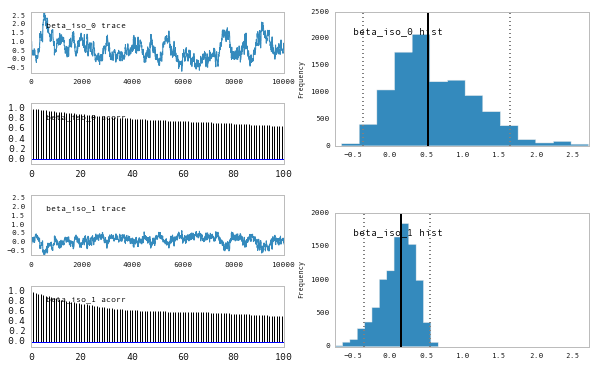

In [103]:
Matplot.plot(M.beta_iso)

Plotting beta_sst_0
Plotting beta_sst_1


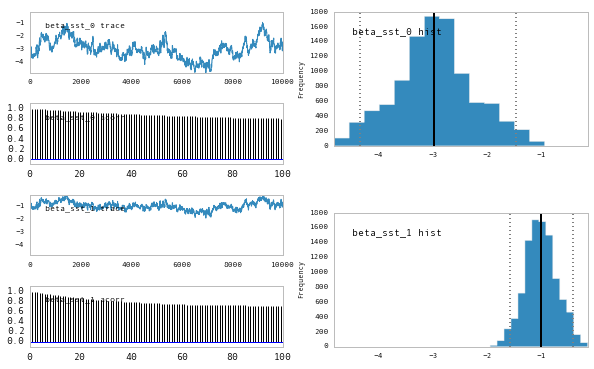

In [100]:
Matplot.plot(M.beta_sst)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


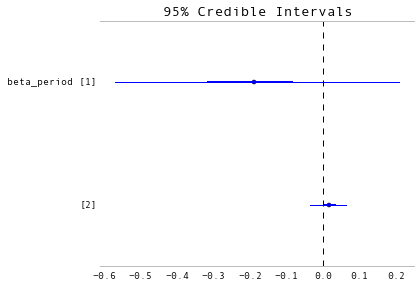

In [104]:
Matplot.summary_plot(M.beta_period)